<a href="https://colab.research.google.com/github/m-wessler/nbm-windgust-better/blob/main/WindGustVerify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install geopandas
!pip install rtree
!pip install pygeos
!pip install cartopy

import os
import requests

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime, timedelta
from multiprocessing import get_context, cpu_count

os.system('tar -xzvf ./output.tar.gz')

     |████████████████████████████████| 12.1MB 341kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 225kB 43.2MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516149 sha256=5f8fc2a4fcf17ea8ad8edbaacd2a37cad1339c2af2c6c63224cf7fee3bb66f97
  Stored in directory: /root/.cache/pip/wheels/45/7f/3b/37879587817fd1bbbee7b47312e2401b4f542cccf2fbe9b4ee
Successfully built cartopy
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37325 sha256=af3b6943ad8e9f5d70c8b2a8c2b6eee2ceb5b760f45d5f26eafe1609a2079268
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp


0

In [7]:
def str_to_int(_v):
    try:
        return int(_v)
    except:
        return np.nan

In [8]:
# Config
timefmt = '%Y%m%d%H%M'
date0 = datetime(2020, 10, 1, 0, 0)
date1 = datetime(2021, 6, 1, 0, 0)

meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
timeseries_base = 'https://api.synopticdata.com/v2/stations/timeseries?'
network_query = '&network=1,2' #1:nws, 2:raws

# Change variable and units here
vars_query = '&vars=wind_gust'
units_query = '&units=english,speed|mph'

api_extras = '&hfmetars=0&qc=on&qc_remove_data=on&qc_flags=off&output=csv'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'

## Obtain Metadata from SynopticLabs (MesoWest) API

In [15]:
zones_shapefile = './geo/wr_zones_30mr21.shp'
zones_shp = gpd.read_file(zones_shapefile)
cwas_shp = zones_shp.dissolve(by='CWA')
cwa_list = cwas_shp.index

cwa_query = '&cwa=%s'%','.join(cwa_list)
url = meta_base + api_token + network_query + cwa_query

api_return = requests.get(url).json()

metadata = pd.DataFrame(api_return['STATION']).set_index('STID')
metadata = metadata[['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']]

# metadata['LATITUDE'] = metadata['LATITUDE'].astype(float)
# metadata['LONGITUDE'] = metadata['LONGITUDE'].astype(float)
metadata['ELEVATION'] = np.array([str_to_int(v) for v in metadata['ELEVATION']])

metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(
    metadata.LONGITUDE, metadata.LATITUDE))

metadata = gpd.clip(metadata, cwas_shp)

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


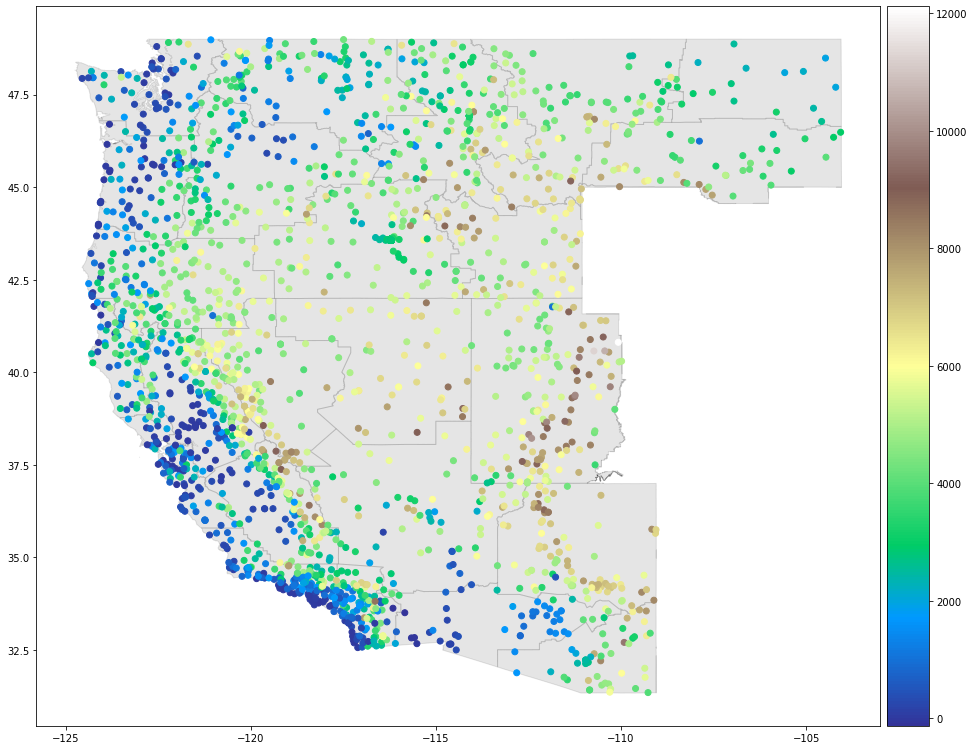

In [47]:
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

def resize_colobar(event):
    # Tell matplotlib to re-draw everything, so that we can get
    # the correct location from get_position.
    plt.draw()

    posn = ax.get_position()
    colorbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                             0.04, axpos.height])

fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w') 
                       #subplot_kw={'projection': ccrs.PlateCarree()})

cwas_shp.plot(column='NAME', color='k', alpha=0.1, edgecolor='k', 
              ax=ax, zorder=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

meta_plot = metadata.dropna()
metadata.plot(column='ELEVATION', cmap='terrain', 
              legend=True, ax=ax, cax=cax, zorder=11)

# ax.add_feature(cartopy.feature.OCEAN, zorder=100, color=None, edgecolor=None)
# ax.coastlines(linewidth=2, zorder=101)

plt.show()
plt.close()

##Obtain observation data from SynopticLabs (MesoWest) API


In [48]:
def parse_api_request(_url):

    api_return = requests.get(_url).json()
        
    df_agg = []
    for i, station_data in enumerate(api_return['STATION']):

        df = pd.DataFrame(station_data['OBSERVATIONS'])
        df.insert(1, 'stid', station_data['STID'])

        # Update this if using for other variables
        df = df.rename(columns={'wind_gust_set_1':'wind_gust'})

        # Grab only the top of the hour ob (1e9 nanosecond stamp to second)
        # Can play with adjusting the 15 min roundoff to as much as +/- 30
        df['date_time'] = df['date_time'].astype(np.datetime64).round('15min')
        df = df.iloc[np.where(df['date_time'].astype(int)%3600e9== 0)]

        # Faster to sort than search
        df = df.sort_values(by='wind_gust', ascending=True)
        df = df.drop_duplicates(subset='date_time', keep='last')
        df = df.set_index(['date_time', 'stid']).sort_index()

        # Optional, drop NaN (no gust or missing)
        df = df.dropna(how='any')

        if df.size > 0:
            df_agg.append(df)

    return pd.concat(df_agg).sort_index()

In [68]:
# Data limits for this many stations requires we break down the request into
# CWAs first then sub-monthly. Adjust the dates as needed if you're getting errs
date_sets = pd.date_range(date0, date1, freq='15D')

observations = []
for cwa in cwa_list:
    cwa_pickle = './output/%s.gust.pd'%cwa

    if not os.path.isfile(cwa_pickle):
        cwa_data = []
        cwa_query = '&cwa=%s'%cwa

        for start, end in zip(date_sets[:-1], date_sets[1:]):
            print('\rWorking %s, %s'%(start.strftime(timefmt), cwa), end='')

            date_query = '&start=%s&end=%s'%(
                start.strftime(timefmt), end.strftime(timefmt))
                            
            url = (timeseries_base + api_token + cwa_query + network_query +
                date_query + vars_query + api_extras)
            
            cwa_data.append(parse_api_request(url))

        cwa_data = pd.concat(cwa_data)
        cwa_data = cwa_data.loc[cwa_data.index.drop_duplicates()]

        cwa_data.to_pickle('./output/%s.gust.pd'%cwa)
        cwa_data.to_csv('./output/%s.gust.csv'%cwa)

    else:
        cwa_data = pd.read_pickle(cwa_pickle)
    
    observations.append(cwa_data)
observations = pd.concat(observations).sort_index()

# Subset the API returns to sites *actually* within the WR CWAs
subset_index = [i for i, index in 
                enumerate(observations.index.get_level_values(1)) 
                if index in metadata.index]

observations = observations.iloc[subset_index]

observations

wind_gust
date_time  stid            
2020-10-01 ABNW1      2.680
           ACRU1      5.366
           ANBC1      5.813
           ASRC1      7.598
           BAFM8     11.174
...                     ...
2021-05-29 WWCO3     11.621
           WWDC1      2.680
           WWRC1      4.023
           YLPO3      4.918
           YNFO3      4.023

[2063648 rows x 1 columns]

## Obtain NBM Data to Match to Obs

In [91]:
 stid = 'KSLC'
 
 url_list = []
for date in pd.date_range(date0, date1, freq='12h'):

    date = pd.to_datetime(date)
    
    # For now pull from the csv generator
    # Best to get API access or store locally later
    base = 'https://hwp-viz.gsd.esrl.noaa.gov/wave1d/data/archive/'
    
    datestr = '{:04d}/{:02d}/{:02d}'.format(date.year, date.month, date.day)
    # Since the wave1d kept 01, 07, 13, 19 inits despite new labels, hour+1
    sitestr = '/NBM4.0/{:02d}/{:s}.csv'.format(date.hour+1, stid)
    
    url = base + datestr + sitestr
    print(date, url)

    wave1d_return = requests.get(url)
    break

wave1d_return

2020-10-01 00:00:00 https://hwp-viz.gsd.esrl.noaa.gov/wave1d/data/archive/2020/10/01/NBM4.0/01/KSLC.csv


<Response [200]>

## Analyze bulk stats, plots, etc...

In [223]:
import io
tempdf = pd.read_csv(io.StringIO(wave1d_return.content.decode('utf-8'))
    )[['ValidTime', 'GUST_10 m above ground']]

tempdf['ValidTime'] = [datetime.strptime(t, '%Y%m%d%H') for t in tempdf['ValidTime'].astype(str)]
tempdf['init_time'] = date
tempdf['stid'] = stid

tempdf = tempdf.rename(
    columns={'ValidTime':'valid_time', 
             'GUST_10 m above ground':'wind_gust'}
             ).set_index(['init_time', 'valid_time', 'stid'])

lead_time = ((tempdf.index.get_level_values(1) - date).days*24*3600 + 
             (tempdf.index.get_level_values(1) - date).seconds)/3600

lead_time_index = ((lead_time >= 0) & (lead_time <= 168) & (lead_time % 6 == 0))

tempdf = tempdf[lead_time_index]
tempdf.insert(0, 'lead_time', lead_time[lead_time_index].astype(int))

tempdf

lead_time  wind_gust
init_time  valid_time          stid                      
2020-10-01 2020-10-01 00:00:00 KSLC          0        NaN
           2020-10-01 06:00:00 KSLC          6        3.3
           2020-10-01 12:00:00 KSLC         12        2.5
           2020-10-01 18:00:00 KSLC         18        4.2
           2020-10-02 00:00:00 KSLC         24        4.4
           2020-10-02 06:00:00 KSLC         30        3.2
           2020-10-02 12:00:00 KSLC         36        3.2
           2020-10-02 18:00:00 KSLC         42        3.8
           2020-10-03 00:00:00 KSLC         48        4.1
           2020-10-03 06:00:00 KSLC         54        3.2
           2020-10-03 12:00:00 KSLC         60        2.8
           2020-10-03 18:00:00 KSLC         66        3.6
           2020-10-04 00:00:00 KSLC         72        4.1
           2020-10-04 06:00:00 KSLC         78        3.6
           2020-10-04 12:00:00 KSLC         84        3.3
           2020-10-04 18:00:00 KSLC         90        4.6
           2020-10-05 00:00:00 KSLC         96        4.0
           2020-10-05 06:00:00 KSLC        102        4.7
           2020-10-05 12:00:00 KSLC        108        3.9
           2020-10-05 18:00:00 KSLC        114        5.0
           2020-10-06 00:00:00 KSLC        120        4.1
           2020-10-06 06:00:00 KSLC        126        3.4
           2020-10-06 12:00:00 KSLC        132        3.0
           2020-10-06 18:00:00 KSLC        138        4.2
           2020-10-07 00:00:00 KSLC        144        4.6
           2020-10-07 06:00:00 KSLC        150        3.4
           2020-10-07 12:00:00 KSLC        156        3.5
           2020-10-07 18:00:00 KSLC        162        5.1
           2020-10-08 00:00:00 KSLC        168        4.4